In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import RidgeClassifier
import numpy as np
import pandas as pd
import glob
from sklearn.metrics import confusion_matrix
from statistics import mean
import scipy.io
import os
import sys
# Initialization of directory information:

# Subjects and tasks
thisDir = os.path.expanduser('~/Desktop/Porteretal_taskprediction/')
dataDir = thisDir + 'data/corrmats/iNetworks/'
outDir = thisDir + 'output/results/Ridge/'
taskList=['slowreveal','mixed']
sesList = ['ses-1','ses-2','ses-3','ses-4']



def model(train_task):
    """
    Preparing machine learning model with appropriate data

    Parameters
    -------------
    train_task : str
            Task name for training
    test_task : str
            Task name for testing

    Returns
    -------------
    within_score : float
            Average accuracy of all folds leave one sub out of a given task
    within_sens : float
            Sensitivity score for model within task
    within spec : float
            Specificity score for model within task
    btn_score : float
            Average accuracy of all folds leave one sub out of a given task
    btn_sens : float
            Sensitivity score for model within task
    btn spec : float
            Specificity score for model within task

    """

    clf=RidgeClassifier()
    loo = LeaveOneOut()
    SSacc_folds=[]
    dfDS=pd.DataFrame()
    #get all subs for a given task
    #make list based on available subjects in task folder
    subList=[]
    pattern = dataDir+train_task+"/*"
    files = [os.path.basename(x) for x in glob.glob(pattern)]
    for i in files:
        subList.append(i.split('_', 1)[0])

    data=np.array(subList,dtype='<U61')
    sessions=np.array(sesList,dtype='<U61')
    for  train, test in loo.split(data): #test on all other subj
        train_sub = data[test] #testing subj
        test_subs = data[train] #training subjs
        #randomly collects one run one session per subj
        testing_set_task = iNets_OS_onerun(train_task, test_subs)
        testing_set_rest = iNets_OS_onerun('rest', test_subs)
        #make sure rest and task sets are the same amount
        y_test_task=np.ones(testing_set_task.shape[0])
        y_test_rest=np.zeros(testing_set_rest.shape[0])
        ytest=np.concatenate((y_test_task,y_test_rest))
        Xtest=np.concatenate((testing_set_task,testing_set_rest))
        #left out sub
        LOS_task=iNetOpenRun(train_task, train_sub[0])
        LOS_rest=iNetOpenRun('rest', train_sub[0])
        task=np.ones(LOS_task.shape[0])
        rest=np.zeros(LOS_rest.shape[0])
        y=np.concatenate((task,rest))
        X=np.concatenate((LOS_task,LOS_rest))
        clf.fit(Xtest,ytest)
        #Same subject
        SSscores=clf.score(X,y)
        SSacc_folds.append(SSscores)

    #SStotal_acc=(mean(SSacc_folds)
    dfDS['acc'] = SSacc_folds
    dfDS.to_csv(outDir+train_task+'_iNets_acc_groupwise.csv',index=False)


def iNets_OS_onerun(train_task, test_subs):
    """
    Calculate FC matrices for all subs in a given task keeping one run randomly
    Parameters
    -----------
    df : str
        Path to file
    Returns
    -----------
    ds : 2D upper triangle FC measures in (roi, days) format

    """
    result_arr = []
    #loop through and append all test sets do each task/rest separate
    for sub in test_subs:
        all_sub_mats = iNetOpenRun(train_task, sub)
        result_arr.append(all_sub_mats)
    result_arr = np.concatenate(result_arr)
    return result_arr

def iNetOpenRun(train_task, sub):
    """
    Convert matlab files into upper triangle np.arrays for a given sub (one run)
    Parameters
    -----------
    df : str
        Path to file
    Returns
    -----------
    ds : 2D upper triangle FC measures in (roi, days) format

    """
    #find all files
    files = glob.glob(dataDir+train_task+'/'+sub+'_ses-*')
    nsess = len(files) #FC matrices
    nrois=333
    ds=np.empty((nsess, int(nrois*(nrois-1)/2)))
    count=0
    for f in files:
    #Consistent parameters to use for editing datasets

        #Load FC file
        fileFC=scipy.io.loadmat(f)

        #Convert to numpy array
        fileFC=np.array(fileFC['parcel_corrmat'])
        #Replace nans and infs with zero
        fileFC=np.nan_to_num(fileFC)
        #Index upper triangle of matrix
        mask=np.triu_indices(nrois,1)

    #Loop through all 10 days to reshape correlations into linear form

        tmp=fileFC[:,:]
        ds[count]=tmp[mask]
        count=count+1
    mask = (ds == 0).all(1)
    column_indices = np.where(mask)[0]
    df = ds[~mask,:]
    #randomly choose 1 run from 1 session
    df=df[np.random.choice(df.shape[0], 1, replace=False), :]
    return df

#for task in taskList:
#    model(task)

def MCmodel():
    """
    Preparing machine learning model with appropriate data

    Parameters
    -------------
    train_task : str
            Task name for training
    test_task : str
            Task name for testing

    Returns
    -------------
    within_score : float
            Average accuracy of all folds leave one sub out of a given task
    within_sens : float
            Sensitivity score for model within task
    within spec : float
            Specificity score for model within task
    btn_score : float
            Average accuracy of all folds leave one sub out of a given task
    btn_sens : float
            Sensitivity score for model within task
    btn spec : float
            Specificity score for model within task

    """

    clf=RidgeClassifier()
    loo = LeaveOneOut()
    SSacc_folds=[]
    dfDS=pd.DataFrame()
    #get all subs for a given task
    #make list based on available subjects in task folder
    subList=[]
    pattern = dataDir+"mixed/*"
    files = [os.path.basename(x) for x in glob.glob(pattern)]
    for i in files:
        subList.append(i.split('_', 1)[0])

    data=np.array(subList,dtype='<U61')
    sessions=np.array(sesList,dtype='<U61')
    for  train, test in loo.split(data): #test on all other subj
        train_sub = data[test] #testing subj
        test_subs = data[train] #training subjs
        #randomly collects one run one session per subj
        testing_set_mix = iNets_OS_onerun('mixed', test_subs)
        testing_set_slow = iNets_OS_onerun('slowreveal', test_subs)
        testing_set_rest = iNets_OS_onerun('rest', test_subs)
        #make sure rest and task sets are the same amount
        y_test_slow=np.full(testing_set_slow.shape[0],2)
        y_test_mix=np.ones(testing_set_mix.shape[0])
        y_test_rest=np.zeros(testing_set_rest.shape[0])
        ytest=np.concatenate((y_test_slow,y_test_mix,y_test_rest))
        Xtest=np.concatenate((testing_set_slow,testing_set_mix,testing_set_rest))
        #left out sub
        LOS_slow=iNetOpenRun('slowreveal', train_sub[0])
        LOS_mix=iNetOpenRun('mixed', train_sub[0])
        LOS_rest=iNetOpenRun('rest', train_sub[0])
        slow=np.full(LOS_slow.shape[0],2)
        mix=np.ones(LOS_mix.shape[0])
        rest=np.zeros(LOS_rest.shape[0])
        y=np.concatenate((slow, mix,rest))
        X=np.concatenate((LOS_slow,LOS_mix,LOS_rest))
        clf.fit(Xtest,ytest)
        #Same subject
        SSscores=clf.score(X,y)
        SSacc_folds.append(SSscores)

    #SStotal_acc=(mean(SSacc_folds)
    dfDS['acc'] = SSacc_folds
    dfDS.to_csv(outDir+'MC_iNets_acc_groupwise.csv',index=False)


def Binarymodel():
    """
    Preparing machine learning model with appropriate data

    Parameters
    -------------
    train_task : str
            Task name for training
    test_task : str
            Task name for testing

    Returns
    -------------
    within_score : float
            Average accuracy of all folds leave one sub out of a given task
    within_sens : float
            Sensitivity score for model within task
    within spec : float
            Specificity score for model within task
    btn_score : float
            Average accuracy of all folds leave one sub out of a given task
    btn_sens : float
            Sensitivity score for model within task
    btn spec : float
            Specificity score for model within task

    """

    clf=RidgeClassifier()
    loo = LeaveOneOut()
    SSacc_folds=[]
    dfDS=pd.DataFrame()
    #get all subs for a given task
    #make list based on available subjects in task folder
    subList=[]
    pattern = dataDir+"mixed/*"
    files = [os.path.basename(x) for x in glob.glob(pattern)]
    for i in files:
        subList.append(i.split('_', 1)[0])

    data=np.array(subList,dtype='<U61')
    sessions=np.array(sesList,dtype='<U61')
    for  train, test in loo.split(data): #test on all other subj
        train_sub = data[test] #testing subj
        test_subs = data[train] #training subjs
        #randomly collects one run one session per subj
        testing_set_mix = iNets_OS_onerun('mixed', test_subs)
        testing_set_slow = iNets_OS_onerun('slowreveal', test_subs)
        testing_set_rest = iNets_OS_onerun('rest', test_subs)
        #make sure rest and task sets are the same amount
        y_test_slow=np.ones(testing_set_slow.shape[0])
        y_test_mix=np.ones(testing_set_mix.shape[0])
        y_test_rest=np.zeros(testing_set_rest.shape[0])
        ytest=np.concatenate((y_test_slow,y_test_mix,y_test_rest))
        Xtest=np.concatenate((testing_set_slow,testing_set_mix,testing_set_rest))
        #left out sub
        LOS_slow=iNetOpenRun('slowreveal', train_sub[0])
        LOS_mix=iNetOpenRun('mixed', train_sub[0])
        LOS_rest=iNetOpenRun('rest', train_sub[0])
        slow=np.ones(LOS_slow.shape[0])
        mix=np.ones(LOS_mix.shape[0])
        rest=np.zeros(LOS_rest.shape[0])
        y=np.concatenate((slow, mix,rest))
        X=np.concatenate((LOS_slow,LOS_mix,LOS_rest))
        clf.fit(Xtest,ytest)
        #Same subject
        SSscores=clf.score(X,y)
        SSacc_folds.append(SSscores)

    #SStotal_acc=(mean(SSacc_folds)
    dfDS['acc'] = SSacc_folds
    dfDS.to_csv(outDir+'Binary_iNets_acc_groupwise.csv',index=False)



In [11]:
clf=RidgeClassifier()
loo = LeaveOneOut()
SSacc_folds=[]
dfDS=pd.DataFrame()
#get all subs for a given task
#make list based on available subjects in task folder
subList=[]
pattern = dataDir+"mixed/*"
files = [os.path.basename(x) for x in glob.glob(pattern)]
for i in files:
    subList.append(i.split('_', 1)[0])
data=np.array(subList,dtype='<U61')
sessions=np.array(sesList,dtype='<U61')
for  train, test in loo.split(data): #test on all other subj
    train_sub = data[test] #testing subj
    test_subs = data[train] #training subjs

In [13]:
subList = list(set(subList))

In [14]:
test_list

['INET018',
 'INET044',
 'INET016',
 'INET047',
 'INET040',
 'INET041',
 'INET045',
 'INET019',
 'INET034',
 'INET051',
 'INET003',
 'INET006',
 'INET050']

/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2314: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  warnings.warn("Calling figure.constrained_layout, but figure not "
/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2314: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  warnings.warn("Calling figure.constrained_layout, but figure not "
/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2314: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called Gri

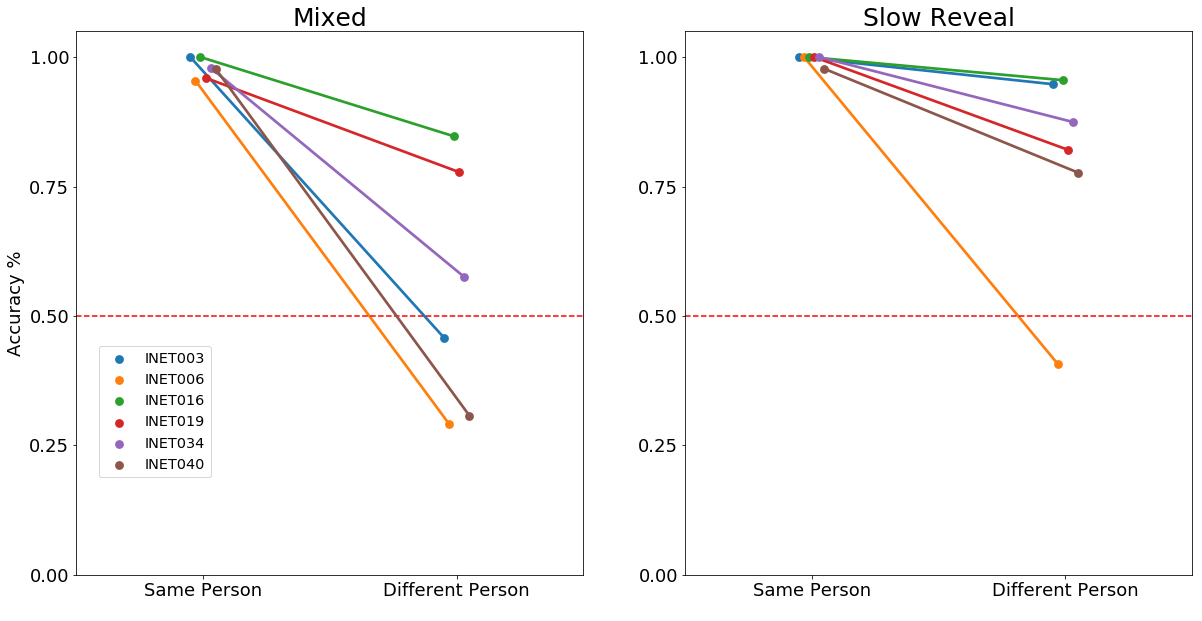

In [66]:
import numpy as np
#import classification
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors as mcolors
from matplotlib.lines import Line2D
import matplotlib.patches as patches
%matplotlib inline 
import os
import sys
figsDir = os.path.expanduser('~/Desktop/Porteretal_taskprediction/output/figures/')
fig=plt.figure(figsize=(20,10), constrained_layout=True)
plt.rcParams['figure.constrained_layout.use'] = True
gs = gridspec.GridSpec(nrows=1, ncols=2,wspace=.2,hspace=.3)
ax1=fig.add_subplot(gs[0,0])

ax=sns.pointplot(x="Analysis",y="acc", hue="subs", ax=ax1,ci=None, data=mixed, dodge=.1,order=['SS','OS'])
ax.set_xticklabels(['Same Person','Different Person'])
ax.set_title('Mixed', fontsize=25, pad=5)
y=[0,.25,.5,.75,1.0]
plt.yticks(y)
plt.ylabel("Accuracy %", fontsize=18)
ax.set(ylim=(0, 1.05))
plt.legend(loc='center left',fontsize='x-large',bbox_to_anchor=(.03, .3))
ax.axhline(.5, ls='--',color='red')
plt.xlabel(' ')
ax.tick_params(labelsize=18)

ax2=fig.add_subplot(gs[0,1])

ax=sns.pointplot(x="Analysis",y="acc", hue="subs", ax=ax2,ci=None, data=slow, dodge=.1,order=['SS','OS'])
ax.set_xticklabels(['Same Person','Different Person'])
ax.set_title('Slow Reveal', fontsize=25, pad=5)
ax.legend_.remove()
y=[0,.25,.5,.75,1.0]
plt.yticks(y)
plt.ylabel(" ", fontsize=18)
ax.set(ylim=(0, 1.05))
ax.axhline(.5, ls='--',color='red')
plt.xlabel(' ')
ax.tick_params(labelsize=18)
plt.savefig(figsDir+'inetworks_CVDS_point_plots.png', bbox_inches='tight')


In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import RidgeClassifier
import numpy as np
import os
import sys
import pandas as pd
import itertools
import glob
import reshape
from statistics import mean
import scipy.io
#import results
import warnings
warnings.filterwarnings("ignore")
# Initialization of directory information:
thisDir = os.path.expanduser('~/Desktop/Porteretal_taskprediction/')
dataDir = thisDir + 'data/corrmats/iNetworks/'
outDir = thisDir + 'output/results/'
figsDir=thisDir + 'output/figures/'
IndNetDir=thisDir+'data/IndNet/'
# Subjects and tasks
taskList=['slowreveal','mixed']
ses = ['ses-1','ses-2','ses-3','ses-4']
#'INET018','INET044','INET045','INET047','INET050','INET051','INET041' add back once resting stat FC are made
subList=['INET003','INET006','INET016','INET019','INET034','INET040']
#all possible combinations of subs and tasks


#make sure rest and task training sets are the same amount


In [14]:
fname = glob.glob(dataDir+'mixed/*')
fname.split("_")#[0]

AttributeError: 'list' object has no attribute 'split'

In [6]:
import reshape
taskFC = reshape.iNets_SS('mixed', 'INET018', 'ses')

restFC = reshape.iNets_SS('rest', 'INET018', 'ses')



In [37]:
t = np.ones(taskFC.shape[0], dtype = int)
r=np.zeros(restFC_sample.shape[0], dtype=int)
y = np.concatenate((t,r))
x = np.concatenate((taskFC, restFC_sample))

In [35]:
restFC_sample

(30, 55278)

In [7]:
import numpy as np

restFC.shape

(62, 55278)

In [9]:
#make sure rest and task training sets are the same amount
restFC[np.random.choice(restFC.shape[0], 1, replace=False), :]

(1, 55278)